MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: March 22, 2021<br>
Last Updated: January 29, 2022<br><br>

**Label: Final Workflow, Script 9**<br>
Script Purpose:<br>
Script for building a simple set of interpolants to compare against the machine learning results.
<br><br>


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [ ]:
#!apt update
#!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install dataprep --no-binary dataprep

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import tree

from collections import Counter

import statsmodels.api as sm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
import pickle as pkl

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

### Set seed for randomized elements in script

In [ ]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper Functions

In [ ]:
## Set Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    #ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    grayval = 255 #224
    ax.background_patch.set_facecolor((grayval/255, grayval/255, grayval/255))

    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', 
                   #edgecolor='r', linewidth=2, alpha = 0.5)
                   edgecolor='k', linewidth=3, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

### Load data from saved pickle file

In [ ]:
datafolder = Path(path) 

#with open(datafolder/ "wellsp4_shared_uniqueOID.pkl","rb") as handle: 
#with open(datafolder/ "wellsp4_shared_uniqueOID.pkl","rb") as handle:
with open(datafolder/ "wells_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf   = datadict['data']
coords   = datadict['coords']
X_train  = datadict['X_train'].reset_index(drop=True)
X_val    = datadict['X_val'].reset_index(drop=True)
X_test   = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)

## Test that plotting works

In [ ]:
tmp = pd.concat([fulldf,coords],axis=1)
train_coords = pd.merge(left=X_train,right=tmp, how='inner',indicator=True)[['Longitude','Latitude']]
tv_coords    = pd.concat([pd.merge(left=X_test,right=tmp, how='inner',indicator=True)[['Longitude','Latitude']],
                          pd.merge(left=X_val, right=tmp, how='inner',indicator=True)[['Longitude','Latitude']]],axis=0).reset_index(drop=True)

yc_tv        = pd.concat([yc_test['GeothermGrad_4class'].cat.codes, yc_val['GeothermGrad_4class'].cat.codes],axis=0).reset_index(drop=True)
yr_tv        = pd.concat([yr_test, yr_val],axis=0).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


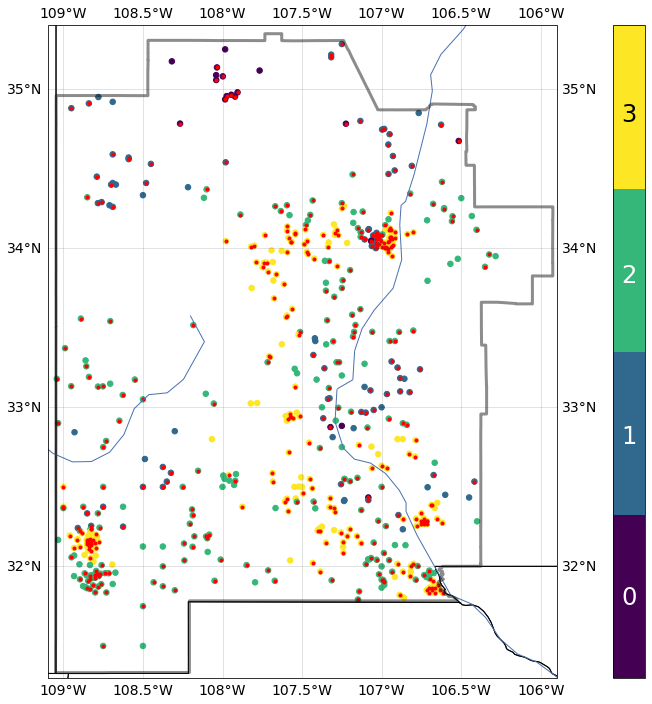

In [ ]:
colmap=plt.cm.get_cmap('viridis', 4)
ax = createBasemap();
gl = ax.gridlines(crs = myprojection, draw_labels=True,
                  linewidth=0.5, color='k', alpha=0.25, linestyle='-')
pc = ax.scatter(coords.Longitude,
                coords.Latitude,
                cmap=colmap,
                s=30,
                c=fulldf.GeothermGrad_4class.cat.codes,
                alpha=1.0,
                transform=myprojection);
cbar = plt.colorbar(pc);
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
  if(j==3):
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
              fontsize='xx-large',fontweight='extra bold')
  else:
    cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                fontsize='xx-large',fontweight='extra bold')
pc = ax.scatter(train_coords.Longitude,
                train_coords.Latitude,
                marker='.',
                c='red',
                alpha=1,
                transform=myprojection);

### Apply different interpolants

Using Piecewise Linear Interpolation:

Model Results
Accuracy (Train) : 1
Accuracy (Test)  : 0.7374
macro F1 (Train): 1.000000
macro F1 (Test) : 0.677057
[[ 5  0  1  0]
 [ 1 14 12  3]
 [ 5  3 46 16]
 [ 0  0  6 67]]
              precision    recall  f1-score   support

       No-GT       0.45      0.83      0.59         6
      Low-GT       0.82      0.47      0.60        30
      Med-GT       0.71      0.66      0.68        70
     High-GT       0.78      0.92      0.84        73

    accuracy                           0.74       179
   macro avg       0.69      0.72      0.68       179
weighted avg       0.75      0.74      0.73       179



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


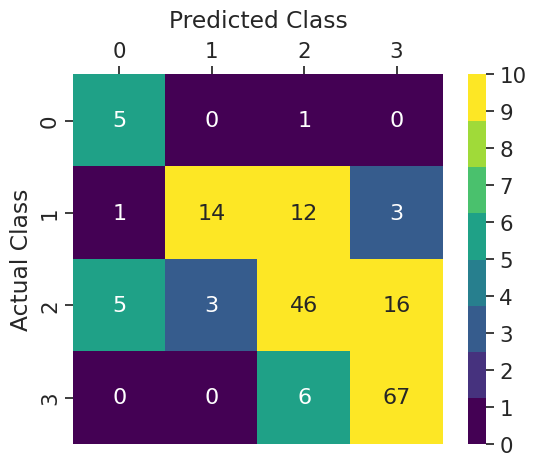

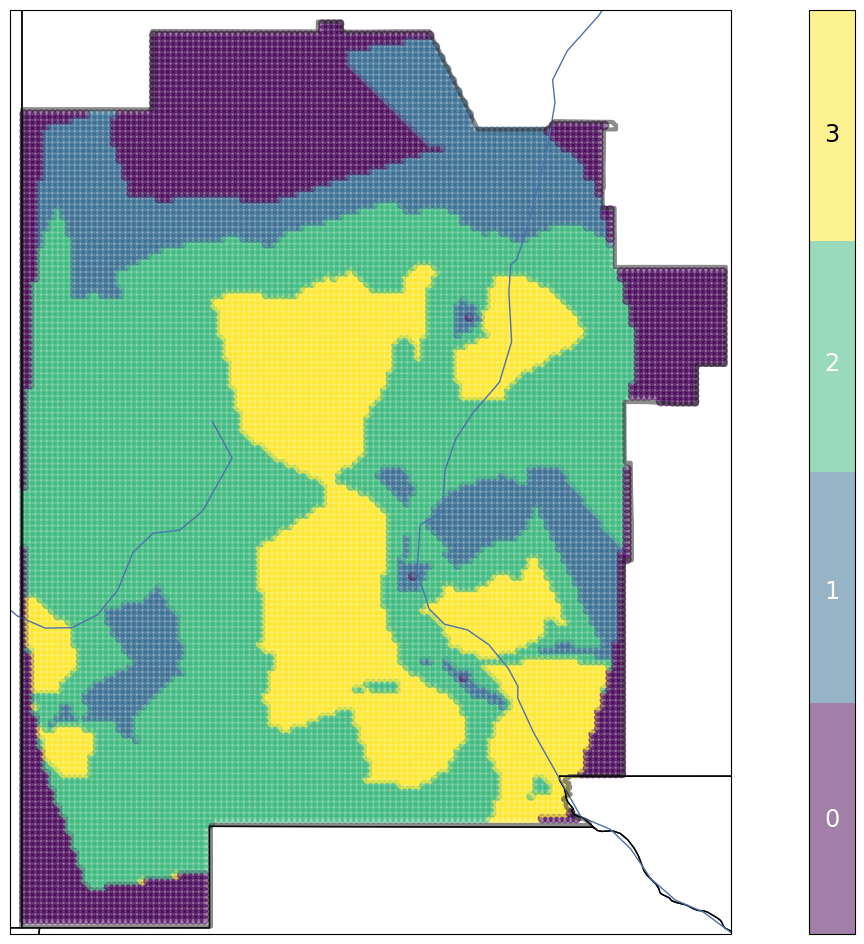

In [ ]:
import scipy.interpolate as interp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import math

# LinearNDInterpolator
## note: fill value set to midway through global average (25-30 K/km)
interpolator = interp.LinearNDInterpolator(np.array([train_coords.Longitude,train_coords.Latitude]).T, yr_train,fill_value=27.5)
print('Using Piecewise Linear Interpolation:')

# check if interpolation worked
#for i in range(5):
#  print(interpolator(train_coords.Longitude[i],train_coords.Latitude[i]),yr_train[i])

# interpolation on test/validate combined points
pred_raw      = interpolator(train_coords.Longitude,train_coords.Latitude)
pred_test_raw = interpolator(tv_coords.Longitude,tv_coords.Latitude)

# convert to classifications
pred = pd.cut(pred_raw,bins = [0,30,40,60,9999], right=False).codes
pred_test = pd.cut(pred_test_raw,bins = [0,30,40,60,9999], right=False).codes

# statistics
print("\nModel Results")
print("Accuracy (Train) : %.4g" % metrics.accuracy_score(yc_train.iloc[:,0].cat.codes, pred))
print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(yc_tv, pred_test))
print("macro F1 (Train): %f" % metrics.f1_score(yc_train.iloc[:,0].cat.codes, pred, average='macro'))
print("macro F1 (Test) : %f" % metrics.f1_score(yc_tv, pred_test,average='macro'))

# create confusion matrix
confusion = confusion_matrix(yc_tv, pred_test)
print(confusion)
print(classification_report(yc_tv, pred_test, 
                            target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  maxval = math.floor(df_cm.sum(axis=0).sum() / 100) * 10
  colmap=plt.cm.get_cmap('viridis', 8)
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap=colmap,vmax=maxval,annot=True,
              fmt='g', annot_kws={"size": 16}, square=True, 
              cbar_kws={'ticks':np.linspace(0,10,11)})
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.savefig(datafolder / 'PiecewiseLinear_WDS_ConfusionMatrix.png', bbox_inches='tight')

with open(datafolder/ "full_shared.pkl","rb") as handle: 
    fulldict = pkl.load(handle)
FULLcoords = fulldict['coords']
FULL_raw = interpolator(FULLcoords.Longitude,FULLcoords.Latitude)
FULL_ypred = pd.cut(FULL_raw,bins = [-9999,30,40,60,9999], right=False).codes

# plot result
with mpl.style.context('default'):
  colmap=plt.cm.get_cmap('viridis', 4)
  ax = createBasemap();
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  c=FULL_ypred,
                  cmap=colmap,
                  alpha=0.5,
                  transform=myprojection);
  cbar = plt.colorbar(pc);
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')
  #plt.savefig(datafolder / 'LR_WDS4_model_prediction_map.png')
  #plt.savefig(datafolder / 'LR_WDS4_model_prediction_map.pdf')

Using Nearest Neighbor Interpolation:

Model Results
Accuracy (Train) : 1
Accuracy (Test)  : 0.7989
macro F1 (Train): 1.000000
macro F1 (Test) : 0.801741
[[ 6  0  0  0]
 [ 1 20  5  4]
 [ 1  4 52 13]
 [ 0  0  8 65]]
              precision    recall  f1-score   support

       No-GT       0.75      1.00      0.86         6
      Low-GT       0.83      0.67      0.74        30
      Med-GT       0.80      0.74      0.77        70
     High-GT       0.79      0.89      0.84        73

    accuracy                           0.80       179
   macro avg       0.79      0.82      0.80       179
weighted avg       0.80      0.80      0.80       179



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


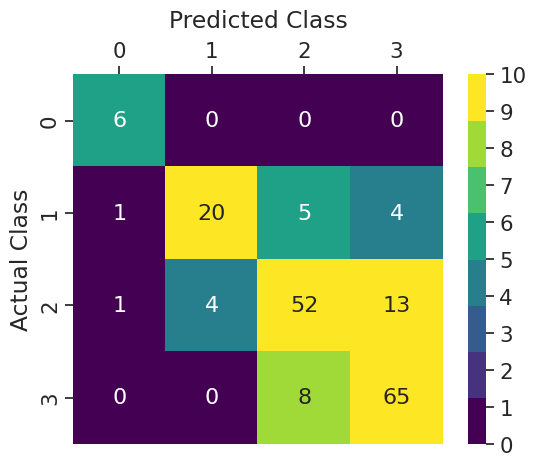

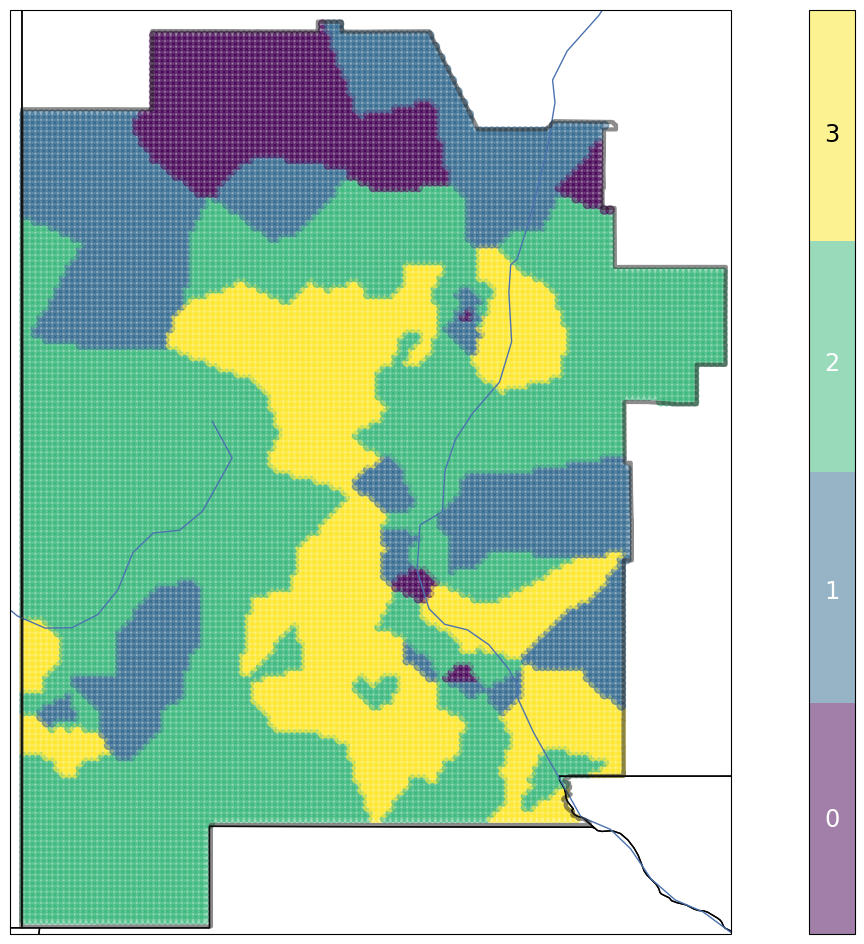

In [ ]:
import scipy.interpolate as interp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# NearestNDInterpolator
## note: fill value set to midway through global average (25-30 K/km)
interpolator = interp.NearestNDInterpolator(np.array([train_coords.Longitude,train_coords.Latitude]).T, yr_train)
print('Using Nearest Neighbor Interpolation:')

# check if interpolation worked
#for i in range(5):
#  print(interpolator(train_coords.Longitude[i],train_coords.Latitude[i]),yr_train[i])

# interpolation on test/validate combined points
pred_raw      = interpolator(train_coords.Longitude,train_coords.Latitude)
pred_test_raw = interpolator(tv_coords.Longitude,tv_coords.Latitude)

# convert to classifications
pred = pd.cut(pred_raw,bins = [0,30,40,60,9999], right=False).codes
pred_test = pd.cut(pred_test_raw,bins = [0,30,40,60,9999], right=False).codes

# statistics
print("\nModel Results")
print("Accuracy (Train) : %.4g" % metrics.accuracy_score(yc_train.iloc[:,0].cat.codes, pred))
print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(yc_tv, pred_test))
print("macro F1 (Train): %f" % metrics.f1_score(yc_train.iloc[:,0].cat.codes, pred, average='macro'))
print("macro F1 (Test) : %f" % metrics.f1_score(yc_tv, pred_test,average='macro'))

# create confusion matrix
confusion = confusion_matrix(yc_tv, pred_test)
print(confusion)
print(classification_report(yc_tv, pred_test, 
                            target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  maxval = math.floor(df_cm.sum(axis=0).sum() / 100) * 10
  colmap=plt.cm.get_cmap('viridis', 8)
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap=colmap,vmax=maxval,annot=True,
              fmt='g', annot_kws={"size": 16}, square=True, 
              cbar_kws={'ticks':np.linspace(0,10,11)})
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.savefig(datafolder / 'NearestNeighbors_WDS_ConfusionMatrix.png', bbox_inches='tight')


FULL_raw = interpolator(FULLcoords.Longitude,FULLcoords.Latitude)
FULL_ypred = pd.cut(FULL_raw,bins = [-9999,30,40,60,9999], right=False).codes

# plot result
with mpl.style.context('default'):
  colmap=plt.cm.get_cmap('viridis', 4)
  ax = createBasemap();
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  c=FULL_ypred,
                  cmap=colmap,
                  alpha=0.5,
                  transform=myprojection);
  cbar = plt.colorbar(pc);
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')

Using Cubic Radial Basis Functions:

Model Results
Accuracy (Train) : 1
Accuracy (Test)  : 0.7709
macro F1 (Train): 1.000000
macro F1 (Test) : 0.727660
[[ 5  1  0  0]
 [ 0 19  6  5]
 [ 2  7 47 14]
 [ 2  1  3 67]]
              precision    recall  f1-score   support

       No-GT       0.56      0.83      0.67         6
      Low-GT       0.68      0.63      0.66        30
      Med-GT       0.84      0.67      0.75        70
     High-GT       0.78      0.92      0.84        73

    accuracy                           0.77       179
   macro avg       0.71      0.76      0.73       179
weighted avg       0.78      0.77      0.77       179



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


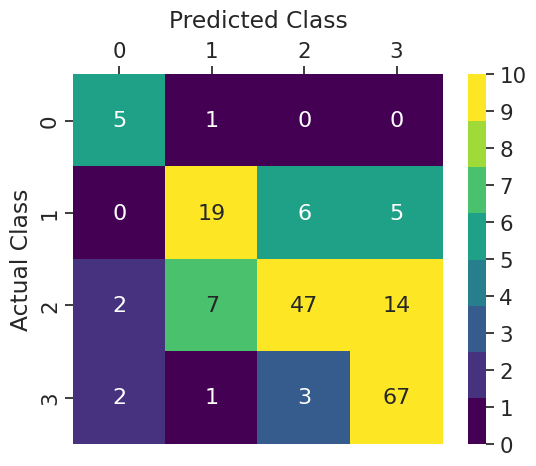

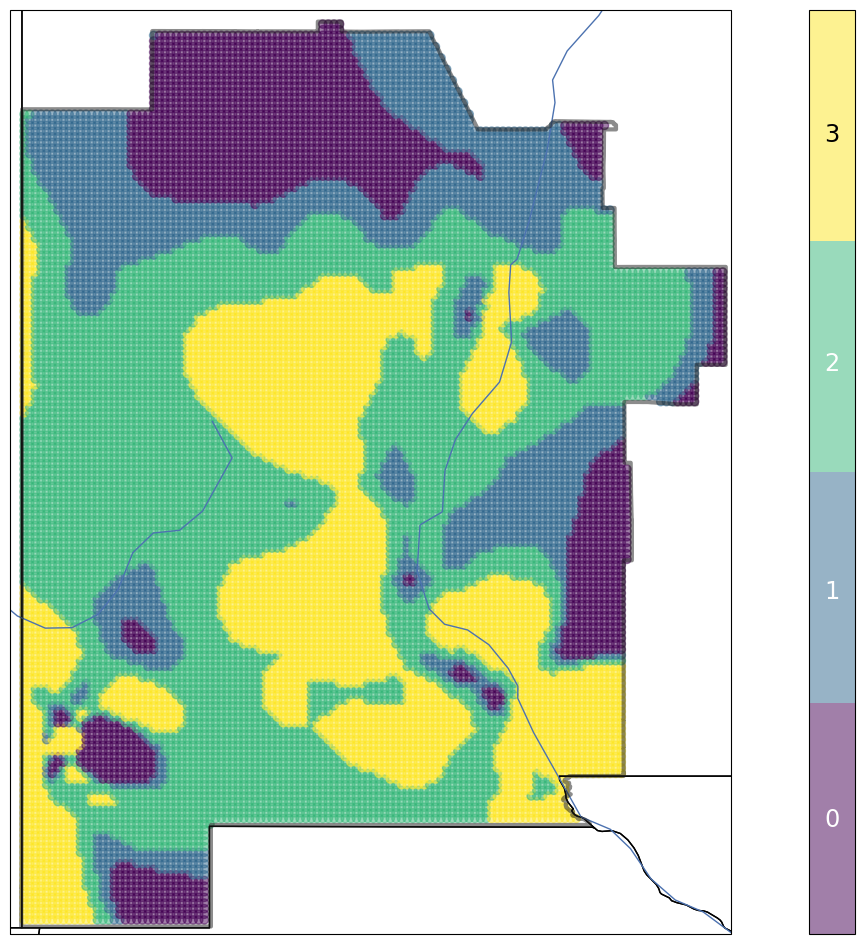

In [ ]:
import scipy.interpolate as interp
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

# RBF
## note: fill value set to midway through global average (25-30 K/km)
interpolator = interp.Rbf(train_coords.Longitude, train_coords.Latitude, yr_train,
                          function='cubic', smooth=0)
print('Using Cubic Radial Basis Functions:')

# check if interpolation worked
#for i in range(5):
#  print(interpolator(train_coords.Longitude[i],train_coords.Latitude[i]),yr_train[i])

# interpolation on test/validate combined points
pred_raw      = interpolator(train_coords.Longitude,train_coords.Latitude)
pred_test_raw = interpolator(tv_coords.Longitude,tv_coords.Latitude)
pred_raw      = np.where(pred_raw<0,27.5,pred_raw)
pred_test_raw = np.where(pred_test_raw<0,27.5,pred_test_raw)

# convert to classifications
pred = pd.cut(pred_raw,bins = [0,30,40,60,9999], right=False).codes
pred_test = pd.cut(pred_test_raw,bins = [0,30,40,60,9999], right=False).codes

# statistics
print("\nModel Results")
print("Accuracy (Train) : %.4g" % metrics.accuracy_score(yc_train.iloc[:,0].cat.codes, pred))
print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(yc_tv, pred_test))
print("macro F1 (Train): %f" % metrics.f1_score(yc_train.iloc[:,0].cat.codes, pred, average='macro'))
print("macro F1 (Test) : %f" % metrics.f1_score(yc_tv, pred_test,average='macro'))

# create confusion matrix
confusion = confusion_matrix(yc_tv, pred_test)
print(confusion)
print(classification_report(yc_tv, pred_test, 
                            target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  maxval = math.floor(df_cm.sum(axis=0).sum() / 100) * 10
  colmap=plt.cm.get_cmap('viridis', 8)
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap=colmap,vmax=maxval,annot=True,
              fmt='g', annot_kws={"size": 16}, square=True, 
              cbar_kws={'ticks':np.linspace(0,10,11)})
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.savefig(datafolder / 'CubicRBF_WDS_ConfusionMatrix.png', bbox_inches='tight')


FULL_raw = interpolator(FULLcoords.Longitude,FULLcoords.Latitude)
FULL_ypred = pd.cut(FULL_raw,bins = [-9999,30,40,60,9999], right=False).codes

# plot result
with mpl.style.context('default'):
  colmap=plt.cm.get_cmap('viridis', 4)
  ax = createBasemap();
  pc = ax.scatter(FULLcoords.Longitude,
                  FULLcoords.Latitude,
                  c=FULL_ypred,
                  cmap=colmap,
                  alpha=0.5,
                  transform=myprojection);
  cbar = plt.colorbar(pc);
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')

In [ ]:
# export point locations for use in ArcGIS for Kriging
# pd.concat([train_coords,yr_train],axis=1).to_csv(datafolder / 'WDS_train_forkriging.csv')
# tv_coords.to_csv(datafolder / 'WDS_testvalidate_forkriging.csv')

# load data from ArcGIS Kriging for analysis
kriging_train = pd.read_csv(datafolder / 'WDS_train_kriging_results.csv')
kriging_tv    = pd.read_csv(datafolder / 'WDS_testvalidate_kriging_results.csv')
kriging_all   = pd.read_csv(datafolder / 'WDS_kriging_results_FULL.csv')


Model Results
Accuracy (Train) : 0.8273
Accuracy (Test)  : 0.7542
macro F1 (Train): 0.798283
macro F1 (Test) : 0.744414
[[ 4  1  1  0]
 [ 0 15 11  4]
 [ 0  0 48 22]
 [ 0  0  5 68]]
              precision    recall  f1-score   support

       No-GT       1.00      0.67      0.80         6
      Low-GT       0.94      0.50      0.65        30
      Med-GT       0.74      0.69      0.71        70
     High-GT       0.72      0.93      0.81        73

    accuracy                           0.75       179
   macro avg       0.85      0.70      0.74       179
weighted avg       0.77      0.75      0.75       179



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The background_patch property is deprecated. Use GeoAxes.patch instead.


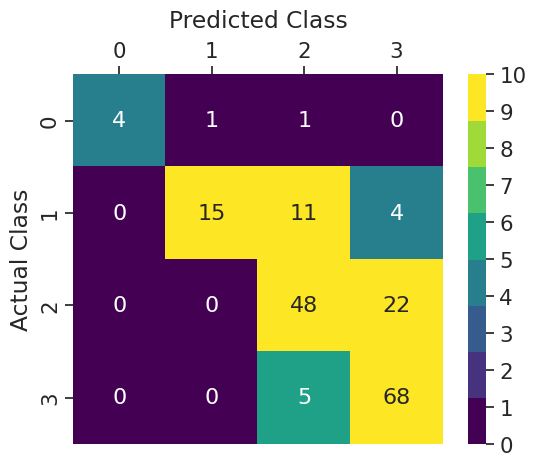

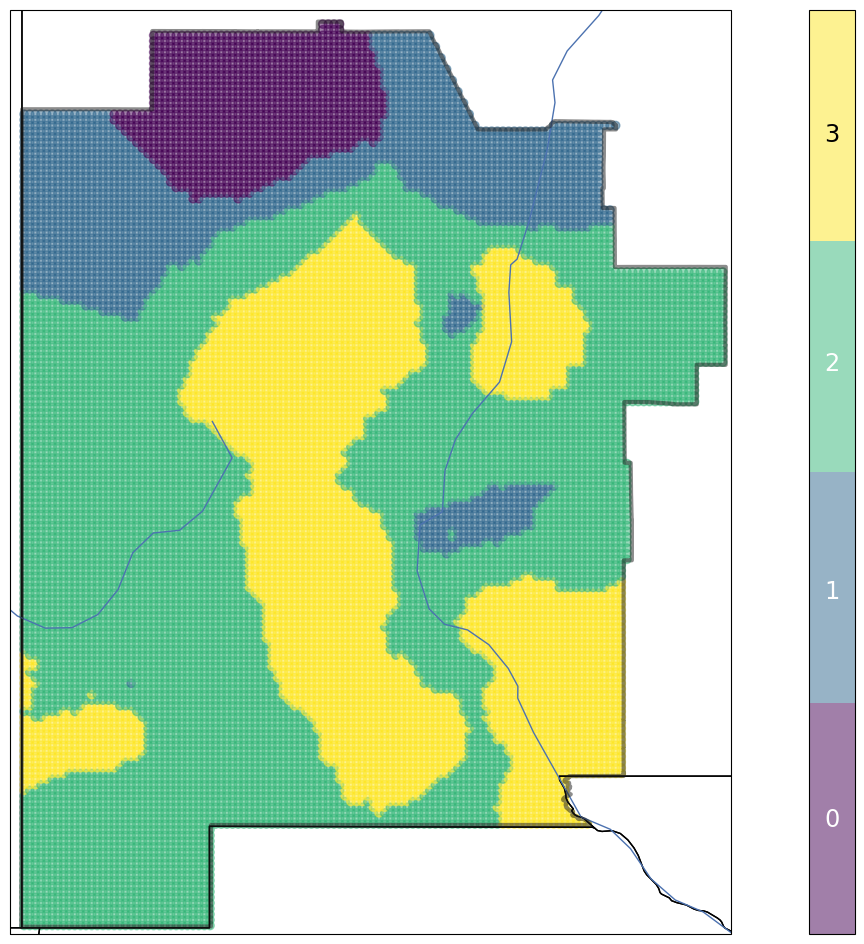

In [ ]:
# interpolation on test/validate combined points
pred_raw      = kriging_train.Kriging_Predicted_Gradient
pred_test_raw = kriging_tv.Kriging_Predicted_Gradient

# convert to classifications
pred      = pd.cut(pred_raw.to_numpy(), bins = [0,30,40,60,9999], right=False).codes
pred_test = pd.cut(pred_test_raw.to_numpy(),bins = [0,30,40,60,9999], right=False).codes

tvdf = pd.concat([kriging_tv,tv_coords, yr_tv,yc_tv],axis=1).drop('Field1',axis=1)

# statistics
print("\nModel Results")
print("Accuracy (Train) : %.4g" % metrics.accuracy_score(pd.cut(kriging_train.GeothermGrad.to_numpy(), bins = [0,30,40,60,9999], right=False).codes, pred))
print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(yc_tv, pred_test))
print("macro F1 (Train): %f" % metrics.f1_score(pd.cut(kriging_train.GeothermGrad.to_numpy(), bins = [0,30,40,60,9999], right=False).codes, pred, average='macro'))
print("macro F1 (Test) : %f" % metrics.f1_score(yc_tv, pred_test,average='macro'))

# create confusion matrix
confusion = confusion_matrix(yc_tv, pred_test)
print(confusion)
print(classification_report(yc_tv, pred_test, 
                            target_names=['No-GT','Low-GT','Med-GT','High-GT']))

with mpl.style.context('default'):
  df_cm = pd.DataFrame(confusion, range(4), range(4))
  maxval = math.floor(df_cm.sum(axis=0).sum() / 100) * 10
  colmap=plt.cm.get_cmap('viridis', 8)
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, cmap=colmap,vmax=maxval,annot=True,
              fmt='g', annot_kws={"size": 16}, square=True, 
              cbar_kws={'ticks':np.linspace(0,10,11)})
  plt.xlabel('Predicted Class',labelpad=10)
  ax = plt.gca()
  ax.xaxis.set_label_position('top') 
  plt.ylabel('Actual Class',labelpad=5)
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  plt.savefig(datafolder / 'Kriging_GP_WDS_ConfusionMatrix.png', bbox_inches='tight')

FULL_raw = kriging_all.Kriging_Predicted_Gradient
FULL_ypred = pd.cut(FULL_raw.to_numpy(),bins = [0,30,40,60,9999], right=False).codes

# plot result
with mpl.style.context('default'):
  colmap=plt.cm.get_cmap('viridis', 4)
  ax = createBasemap();
  pc = ax.scatter(kriging_all.Longitude,
                  kriging_all.Latitude,
                  c=FULL_ypred,
                  cmap=colmap,
                  alpha=0.5,
                  transform=myprojection);
  cbar = plt.colorbar(pc);
  cbar.ax.get_yaxis().set_ticks([])
  for j, lab in enumerate(['$0$','$1$','$2$','$3$']):
    if(j==3):
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='black',
                fontsize='xx-large',fontweight='extra bold')
    else:
      cbar.ax.text(1.5,(2*j+1)/2.7, lab, ha='center', va='center',c='white',
                  fontsize='xx-large',fontweight='extra bold')